# 02 — Portfolio: Rolling Rebalance (Max-Sharpe, Monthly) + Metrics
ขั้นตอน: โหลดราคา → คำนวณผลตอบแทนรายวัน → Rolling window 252 วัน → สร้างน้ำหนัก Max-Sharpe รายเดือน → ผลตอบแทนกลยุทธ์ → Metrics (Sharpe, CAGR, MaxDD, Vol) + เทียบ Equal-Weight

In [ ]:
%pip -q install yfinance pandas numpy matplotlib scikit-learn scipy


In [ ]:
import yfinance as yf, pandas as pd, numpy as np, matplotlib.pyplot as plt, os
from sklearn.covariance import LedoitWolf
from scipy.optimize import minimize

# ---------- Parameters ----------
TICKERS = ["PTT.BK","AOT.BK","SCB.BK","CPALL.BK","ADVANC.BK"]  # แก้ได้
START = "2015-01-01"
END   = "2025-08-28"
LOOKBACK_DAYS = 252   # window สำหรับคำนวณ mean/cov
REBAL_FREQ = "M"      # รายเดือน
RF_ANNUAL = 0.0       # risk-free สำหรับ Sharpe (ปรับตามมุมมอง)

# ---------- Load prices ----------
px = yf.download(TICKERS, start=START, end=END, auto_adjust=False)["Adj Close"].ffill().dropna(how="all")
rets = px.pct_change().dropna()
print("Prices:", px.shape, "Returns:", rets.shape)
px.tail(3)


[*********************100%***********************]  5 of 5 completed

Prices: (2587, 5) Returns: (812, 5)


Ticker,ADVANC.BK,AOT.BK,CPALL.BK,PTT.BK,SCB.BK
Date,,,,,
2025-08-25,291.0,38.00,45.75,32.25,129.0
2025-08-26,298.0,37.00,45.00,32.00,127.0
2025-08-27,299.0,36.75,44.75,31.75,127.5


In [ ]:
from typing import Dict

def max_sharpe_weights(rw: pd.DataFrame, rf_annual=0.0) -> np.ndarray:
    """คำนวณน้ำหนัก Max-Sharpe จากหน้าต่าง rolling (daily returns DataFrame)"""
    n = rw.shape[1]
    mu_ann = rw.mean().values * 252
    cov_ann = LedoitWolf().fit(rw.values).covariance_ * 252
    bounds = [(0,1)] * n
    cons = [{"type":"eq","fun": lambda w: np.sum(w) - 1}]
    def neg_sharpe(w):
        w = np.asarray(w)
        ret = w @ mu_ann
        vol = np.sqrt(w @ cov_ann @ w) + 1e-12
        return -( (ret - rf_annual) / vol )
    x0 = np.ones(n)/n
    res = minimize(neg_sharpe, x0, method="SLSQP", bounds=bounds, constraints=cons, options={"maxiter":200})
    return res.x

def perf_metrics(returns: pd.Series, periods_per_year=252, rf=0.0) -> Dict[str, float]:
    r = returns.dropna()
    if len(r) == 0:
        return {"CAGR": np.nan, "Vol": np.nan, "Sharpe": np.nan, "MaxDD": np.nan}
    cum = (1 + r).cumprod()
    years = len(r) / periods_per_year
    cagr = float(cum.iloc[-1]**(1/years) - 1) if years > 0 else np.nan
    vol = float(r.std() * np.sqrt(periods_per_year))
    sharpe = float((r.mean()*periods_per_year - rf) / (vol + 1e-12))
    roll_max = cum.cummax()
    dd = (cum/roll_max - 1.0)
    mdd = float(dd.min())
    return {"CAGR": cagr, "Vol": vol, "Sharpe": sharpe, "MaxDD": mdd}


In [ ]:
# ---------- Rebalance dates ----------
rebal_dates = rets.resample(REBAL_FREQ).last().index

weights_records = []
port_rets = pd.Series(dtype=float)  # จะต่อซีรีส์ผลตอบแทนรายวันของพอร์ต

for d in rebal_dates:
    # ให้ d_eff เป็นวันที่เทรดจริงที่ใกล้ที่สุด (ถ้าตรงวันหยุด จะเลื่อนไปวันก่อนหน้า)
    if d in rets.index:
        d_eff = d
    else:
        pos = rets.index.searchsorted(d, side="right") - 1
        if pos <= 0:
            continue
        d_eff = rets.index[pos]

    # เลือกหน้าต่างย้อนหลัง LOOKBACK_DAYS วันก่อน d_eff
    end_loc = rets.index.get_loc(d_eff)
    start_loc = end_loc - LOOKBACK_DAYS
    if start_loc <= 0:
        continue
    rw = rets.iloc[start_loc:end_loc]  # ข้อมูลอดีตเท่านั้น

    # หา weights แบบ Max Sharpe
    w = max_sharpe_weights(rw, rf_annual=RF_ANNUAL)
    weights_records.append(pd.Series(w, index=rets.columns, name=d_eff))

    # ช่วงถือครอง: ตั้งแต่วันถัดจาก d_eff จนถึงวัน rebal ถัดไป (รวมวันสุดท้าย)
    try:
        next_d = rebal_dates[rebal_dates.get_loc(d)+1]
    except Exception:
        next_d = rets.index[-1]
    # แปลง next_d เป็นวันเทรดจริง
    if next_d in rets.index:
        next_eff = next_d
    else:
        pos2 = rets.index.searchsorted(next_d, side="right") - 1
        next_eff = rets.index[max(pos2, end_loc+1)]

    hold = rets.loc[(rets.index > d_eff) & (rets.index <= next_eff)]
    if len(hold) == 0:
        continue
    daily_port = hold @ w  # ผลตอบแทนพอร์ตแบบ dot weight
    port_rets = pd.concat([port_rets, daily_port])

# ---------- Save outputs ----------
weights_df = pd.DataFrame(weights_records)
weights_df.to_csv("rolling_weights_max_sharpe.csv")
port_rets.to_csv("rolling_rebalance_returns.csv", header=["ret"])
print("Saved: rolling_weights_max_sharpe.csv", weights_df.shape)
print("Saved: rolling_rebalance_returns.csv", port_rets.shape)


/tmp/ipython-input-52477777.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rebal_dates = rets.resample(REBAL_FREQ).last().index
/tmp/ipython-input-52477777.py:44: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  port_rets = pd.concat([port_rets, daily_port])


Saved: rolling_weights_max_sharpe.csv (28, 5)
Saved: rolling_rebalance_returns.csv (543,)


Saved: strategy_performance_metrics.csv


,Strategy,CAGR,Vol,Sharpe,MaxDD
0,Rolling_MaxSharpe,0.099321,0.159347,0.673863,-0.168338
1,EqualWeight_proxy,0.023998,0.145666,0.235534,-0.212304


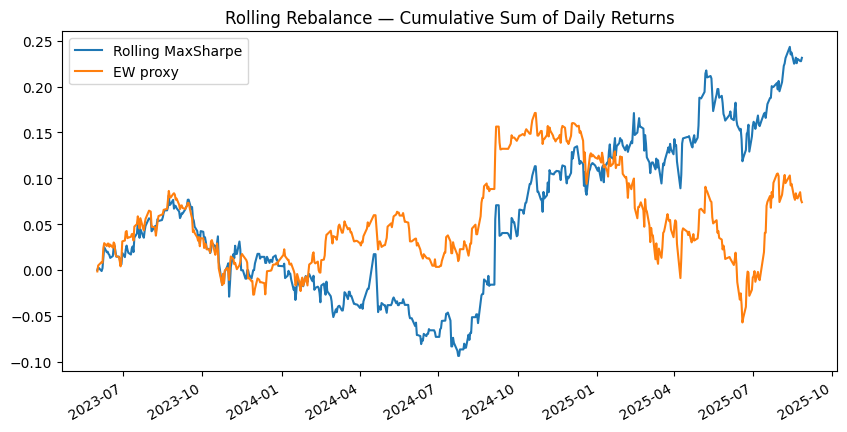

In [ ]:
# Benchmark: Equal-Weight (ถือเท่ากันทุกวัน)
ew = rets.mean(axis=1)  # proxy agg (เท่ากันทุกตัว, ไม่ rebal รายวันละเอียด)
# คุณสามารถทำ EW รายเดือนแบบคำนวณ weights รายเดือนคล้าย Max-Sharpe ได้เช่นกัน

# Metrics
met_roll = perf_metrics(port_rets, periods_per_year=252, rf=RF_ANNUAL)
met_ew   = perf_metrics(ew.reindex(port_rets.index).dropna(), periods_per_year=252, rf=RF_ANNUAL)

df_mets = pd.DataFrame([
    {"Strategy":"Rolling_MaxSharpe", **met_roll},
    {"Strategy":"EqualWeight_proxy", **met_ew},
])
df_mets.to_csv("strategy_performance_metrics.csv", index=False)
print("Saved: strategy_performance_metrics.csv")
display(df_mets)

# Plot cumulative returns
ax = (port_rets.cumsum()).plot(figsize=(10,5), label="Rolling MaxSharpe")
ew.reindex(port_rets.index).cumsum().plot(ax=ax, label="EW proxy")
plt.title("Rolling Rebalance — Cumulative Sum of Daily Returns")
plt.legend(); plt.show()


Saved drawdown_maxsharpe.csv | min=-0.1683
Saved drawdown_ew.csv        | min=-0.2123


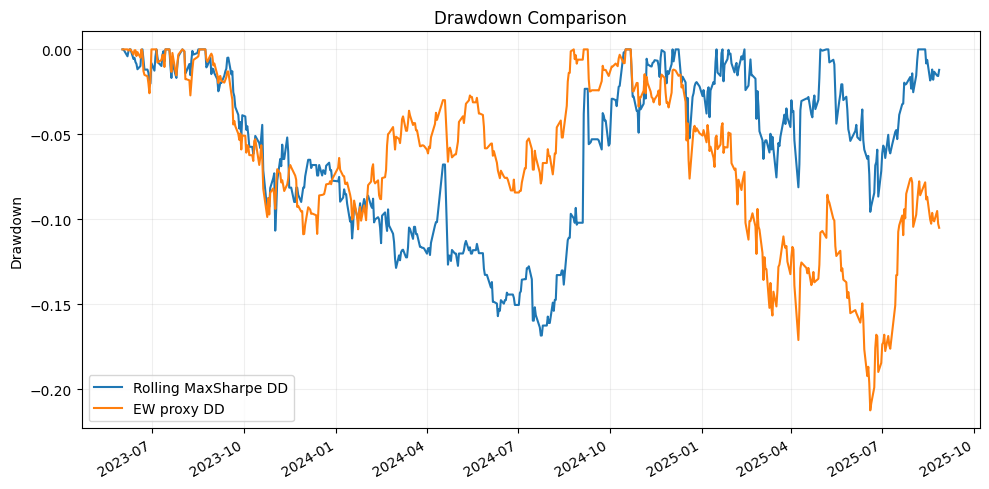

MaxDD (MaxSharpe): -16.83% | MaxDD (EW): -21.23%


In [ ]:
# === Drawdown utilities ===
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import os

def compute_drawdown(returns: pd.Series):
    """รับ daily simple returns -> คืน (cum, peak, drawdown, max_dd)"""
    r = returns.dropna().copy()
    cum = (1 + r).cumprod()
    peak = cum.cummax()
    dd = (cum / peak) - 1.0
    max_dd = float(dd.min()) if len(dd) else np.nan
    return cum, peak, dd, max_dd

# โหลดซีรีส์ผลตอบแทนจากไฟล์ (ถ้า runtime ใหม่)
if "port_rets" not in globals() or port_rets is None or len(port_rets)==0:
    rr = pd.read_csv("rolling_rebalance_returns.csv", index_col=0, parse_dates=True)
    port_rets = rr.iloc[:,0]
if "ew" not in globals() or ew is None or len(ew)==0:
    # สร้าง EW proxy จาก rets ที่อยู่ใน scope เดิม
    # ถ้าไม่มี rets ใน memory ให้สร้างจากราคาที่ดาวน์โหลดก่อนหน้า
    try:
        ew = rets.mean(axis=1)
    except:
        raise RuntimeError("ไม่พบตัวแปร rets ใน memory — โปรดรันเซลล์โหลดราคาก่อน หรือกำหนด EW เอง")

# คำนวณ drawdown
cum_ms, peak_ms, dd_ms, maxdd_ms = compute_drawdown(port_rets)
cum_ew, peak_ew, dd_ew, maxdd_ew = compute_drawdown(ew.reindex(port_rets.index).dropna())

# เซฟเป็นไฟล์สำหรับอ้างอิง
dd_ms.to_csv("drawdown_maxsharpe.csv", header=["drawdown"])
dd_ew.to_csv("drawdown_ew.csv", header=["drawdown"])
print(f"Saved drawdown_maxsharpe.csv | min={dd_ms.min():.4f}")
print(f"Saved drawdown_ew.csv        | min={dd_ew.min():.4f}")

# วาดกราฟ drawdown เทียบกัน
plt.figure(figsize=(10,5))
dd_ms.plot(label="Rolling MaxSharpe DD")
dd_ew.plot(label="EW proxy DD")
plt.title("Drawdown Comparison")
plt.ylabel("Drawdown")
plt.legend()
plt.grid(alpha=0.2)
plt.tight_layout()
plt.savefig("drawdown_comparison.png", dpi=150)
plt.show()

print(f"MaxDD (MaxSharpe): {maxdd_ms:.2%} | MaxDD (EW): {maxdd_ew:.2%}")
